# Logistic Regression

我们将建立一个逻辑回归模型来预测一个学生是否被大学录取。假设你是一个大学系的管理员，你想根据两次考试的结果来决定每个申请人的录取机会。你有以前的申请人的历史数据，你可以用它作为逻辑回归的训练集。对于每一个培训例子，你有两个考试的申请人的分数和录取决定。为了做到这一点，我们将建立一个分类模型，根据考试成绩估计入学概率。

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import os
path = 'data' + os.sep + 'LogiReg_data.txt'

# 默认情况下header=0，表示将csv文件的第一行当作列名，即列索引
# header=None表示不将csv文件的第一行当作列名，而是直接作为样本
# 此时可以使用names参数来指定列索引
pdData = pd.read_csv(path, header=None, names=['Exam 1', 'Exam 2', 'Admitted'])
pdData.head()

,Exam 1,Exam 2,Admitted
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


In [3]:
pdData.shape

(100, 3)

Text(0, 0.5, 'Exam 2 Score')

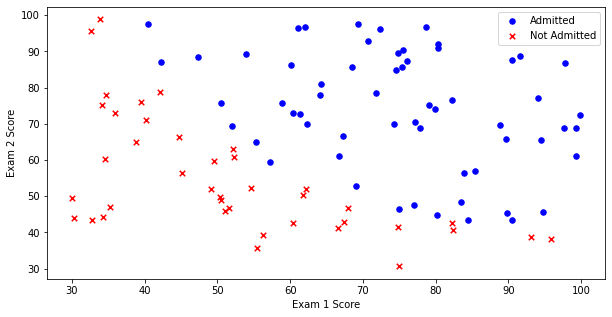

In [4]:
# returns the subset of rows such Admitted = 1, i.e. the set of *positive* examples
positive = pdData[pdData['Admitted'] == 1]

# returns the subset of rows such Admitted = 0, i.e. the set of *negative* examples
negative = pdData[pdData['Admitted'] == 0] 

# 绘制散点图观察数据分布
fig, ax = plt.subplots(figsize=(10,5))

# s参数表示点的大小，c参数是点的颜色
ax.scatter(positive['Exam 1'], positive['Exam 2'], s=30, c='b', marker='o', label='Admitted')
ax.scatter(negative['Exam 1'], negative['Exam 2'], s=30, c='r', marker='x', label='Not Admitted')
ax.legend()
ax.set_xlabel('Exam 1 Score')
ax.set_ylabel('Exam 2 Score')

## The logistic regression

目标：建立分类器(求解出三个参数 $\theta_0         \theta_1         \theta_2 $), $\theta_0$是x0的权重项，通常x0=1，且x0这一列需要自己添加


设定阈值，根据阈值判断录取结果

### 要完成的模块
-  `sigmoid` : 映射到概率的函数

-  `model` : 返回预测结果值

-  `cost` : 根据参数计算损失

-  `gradient` : 计算每个参数的梯度方向

-  `descent` : 进行参数更新

-  `accuracy`: 计算精度

###  `sigmoid` 函数

$$
g(z) = \frac{1}{1+e^{-z}}   
$$

In [5]:
# 定义sigmoid函数
def sigmoid(z): return 1 / (1 + np.exp(-z))

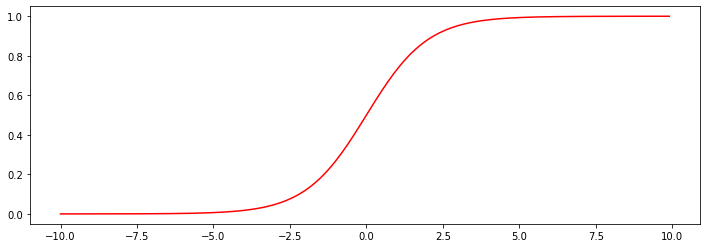

In [6]:
nums = np.arange(-10, 10, step=0.1)

# 绘制sigmoid函数的曲线
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(nums, sigmoid(nums), 'r')

### Sigmoid
* $g:\mathbb{R} \to [0,1]$
* $g(0)=0.5$
* $g(- \infty)=0$
* $g(+ \infty)=1$


### 数据处理步骤:

1. 先在数据中添加一列x0，x0全为1，主要是为了计算常数项$\theta_0$

2. 将pandas转化成numpy

3. 分离出训练数据X，标签值y(标签值通常是数据的最后一列)

4. 打乱样本


In [7]:
# 为了方便矩阵运算，在数据中插入新的一列，这一列全为1，即x0
pdData.insert(0, 'Ones', 1) 

# set X (training data) and y (target variable)
# convert the Pandas representation of the data to an array useful for further computations
# 将pandas转换成numpy数组，用values属性即可
orig_data = pdData.values

# 拿出训练数据X和标签值y
cols = orig_data.shape[1]
X = orig_data[:, 0:cols-1]

# 这里必须写成orig_data[:, cols-1:cols]
# 而不能写成orig_data[:, cols-1]
# 前者得到的是一个列向量，后者得到行向量
# 因为前者是切片，后者是索引，具体区别已经在笔记中介绍过
y = orig_data[:, cols-1:cols]

# initalize the parameter array theta
# 构造一个1*3的全0数组，即初始化的θ数组
theta = np.zeros([1, 3])

In [8]:
# 查看前5行训练数据，第一列就是x0
X[:5]

array([[ 1.        , 34.62365962, 78.02469282],
       [ 1.        , 30.28671077, 43.89499752],
       [ 1.        , 35.84740877, 72.90219803],
       [ 1.        , 60.18259939, 86.3085521 ],
       [ 1.        , 79.03273605, 75.34437644]])

In [9]:
y[:5]

array([[0.],
       [0.],
       [0.],
       [1.],
       [1.]])

In [10]:
theta, theta.T

(array([[0., 0., 0.]]),
 array([[0.],
        [0.],
        [0.]]))

In [11]:
X.shape, y.shape, theta.shape, theta.T.shape

((100, 3), (100, 1), (1, 3), (3, 1))

### 损失函数
将对数似然函数去负号，注意逻辑回归的$h_\theta(x)$函数和线性回归的$h_\theta(x)$函数是不一样的！

$$
D(h_\theta(x), y) = -y\log(h_\theta(x)) - (1-y)\log(1-h_\theta(x))
$$
求平均损失, n表示样本数
$$
J(\theta)=\frac{1}{n}\sum_{i=1}^{n} D(h_\theta(x_i), y_i)
$$

In [12]:
# 计算每一个样本的sigmoid函数值，即把线性回归的计算结果映射到[0, 1]之间
# 注意是矩阵相乘，所以需要转置theta
# X的形状是(100, 3), theta.T的形状是(3, 1), 返回的结果形状是(100, 1), 即一个列向量
def model(X, theta): return sigmoid(np.dot(X, theta.T))

In [13]:
# 根据公式计算损失值，即求𝐷(ℎ𝜃(𝑥),𝑦) = −𝑦log(ℎ𝜃(𝑥))−(1−𝑦)log(1−ℎ𝜃(𝑥))
def cost(X, y, theta):
    left = np.multiply(-y, np.log(model(X, theta)))
    right = np.multiply(1 - y, np.log(1 - model(X, theta)))
    return np.sum(left - right) / (len(X))

In [14]:
# 使用初始的theta数组计算损失值
cost(X, y, theta)

0.6931471805599453

### 计算梯度(理解这一步至关重要！)


$$
\frac{\partial J}{\partial \theta_j}=-\frac{1}{n}\sum_{i=1}^n (y_i - h_\theta (x_i))x_{ij}
$$

根据这个公式就可以计算出第j个特征的权重参数θj的梯度，如果只有1个样本，那么只需要计算出该样本与真实值的误差(即y - hθ(x))，再将误差乘以第j个特征的值(即xj)，就可以得到θj的梯度

如果有多个样本，假设有100个，那就需要先计算出这100个样本每个样本与真实值的误差，可以得到一个长度为100的误差向量，然后将误差向量乘以第j个特征对应的向量(相当于第i个样本的误差乘以第i个样本的第j个特征的值)，最后求和取平均数作为θj的梯度


In [15]:
# 计算每个θ的梯度，这里是求偏导数
def gradient(X, y, theta):
    
    # grad用来保存计算好的θ，形状和theta一样，初始值全为0
    grad = np.zeros(theta.shape)
    
    # 根据公式，error计算的是yi-hθ(xi), 下面把负号放进去了所以是hθ(xi)-yi
    # ravel()函数的作用是将高维数组转化成一维数组，方便下面的运算
    error = (model(X, theta) - y).ravel()
    
    # 如果θ向量的长度是3，则需要循环三次，即每个特征的θ计算一次
    for j in range(len(theta.ravel())): 
        
        # 得到error后，根据公式，乘以xij
        # 因为X是一个向量，所以直接乘一列，即xj
        term = np.multiply(error, X[:, j])
        
        # 求和取平均，将结果保存到grad数组中
        grad[0, j] = np.sum(term) / len(X)
    
    return grad

### Gradient descent

比较3中不同梯度下降方法


In [16]:
STOP_ITER = 0
STOP_COST = 1
STOP_GRAD = 2

def stopCriterion(type, value, threshold):
    
    # 设定三种不同的停止策略
    if type == STOP_ITER: # 根据迭代次数停止      
        return value > threshold
    elif type == STOP_COST: # 根据损失值的大小停止
        return abs(value[-1]-value[-2]) < threshold
    elif type == STOP_GRAD:      
        return np.linalg.norm(value) < threshold

In [17]:
import numpy.random

# 打乱数据
def shuffleData(data):
    
    np.random.shuffle(data)
    
    # 取列数
    cols = data.shape[1]
    
    # 取特征值
    X = data[:, 0:cols-1]
    
    # 取标签值，即数据的最后一列，所以是cols-1
    y = data[:, cols-1:]
    
    return X, y

In [18]:
import time

# alpha是学习率，thresh是对应停止策略的阈值，batchSize指定每轮迭代使用多少个样本
def descent(data, theta, batchSize, stopType, thresh, alpha):
    
    # 获取当前时间，用于计算时间差，单位是秒
    # time.time()返回一个浮点数，即格林尼治时间1970年1月1日00:00:00到当前时刻的时长，时长单位是秒
    init_time = time.time()
    
    i = 0 # 迭代次数
    k = 0 # 当前已经训练的样本数
    
    X, y = shuffleData(data)
    costs = [cost(X, y, theta)] # 损失值，加中括号是为了转换成列表

    while True:
        
        # 取第k到k+batchSize个数据进行计算
        # 得到本次计算的θ的梯度
        grad = gradient(X[k:k + batchSize], y[k:k + batchSize], theta)
        
        k += batchSize #每次取batchSize个数据
        
        # n是所有样本的数量，在下面的代码块中有定义
        if k >= n: 
            k = 0 
            X, y = shuffleData(data) #重新洗牌
            
        theta = theta - alpha * grad # 参数更新
        costs.append(cost(X, y, theta)) # 计算新的损失
        i += 1 # 迭代次数+1

        if stopType == STOP_ITER:       value = i
        elif stopType == STOP_COST:     value = costs
        elif stopType == STOP_GRAD:     value = grad
        
        # 如果已经达到停止迭代的条件，退出循环
        if stopCriterion(stopType, value, thresh): break
    
    return theta, i-1, costs, grad, time.time() - init_time

In [19]:
# 运行实验
def runExpe(data, theta, batchSize, stopType, thresh, alpha):
    
    theta, iter, costs, grad, dur = descent(data, theta, batchSize, stopType, thresh, alpha)
    
    name = "Original" if (data[:, 1] > 2).sum() > 1 else "Scaled"
    
    name += " data - learning rate: {} - ".format(alpha)
    if batchSize==n: strDescType = "Gradient"
    elif batchSize==1:  strDescType = "Stochastic"
    else: strDescType = "Mini-batch ({})".format(batchSize)
        
    name += strDescType + " descent - Stop: "
    if stopType == STOP_ITER: strStop = "{} iterations".format(thresh)
    elif stopType == STOP_COST: strStop = "costs change < {}".format(thresh)
    else: strStop = "gradient norm < {}".format(thresh)
        
    name += strStop
    print ("***{}\nTheta: {} - Iter: {} - Last cost: {:03.2f} - Duration: {:03.2f}s".format(
        name, theta, iter, costs[-1], dur))
    
    # 绘图
    fig, ax = plt.subplots(figsize=(12,4))
    ax.plot(np.arange(len(costs)), costs, 'r')
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Cost')
    ax.set_title(name.upper() + ' - Error vs. Iteration')
    
    return theta

### 不同的停止策略

#### 设定迭代次数

***Original data - learning rate: 1e-06 - Gradient descent - Stop: 5000 iterations
Theta: [[-0.00027127  0.00705232  0.00376711]] - Iter: 5000 - Last cost: 0.63 - Duration: 0.62s


array([[-0.00027127,  0.00705232,  0.00376711]])

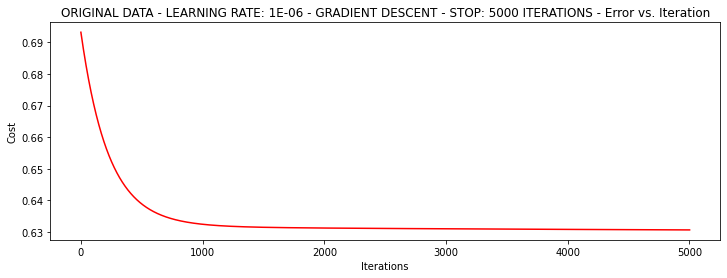

In [20]:
# 选择的梯度下降方法是基于所有样本的
# n是所有样本的数量
n = 100

# 根据迭代次数停止训练，这里设置次数为5000次
# 最终损失值为0.63
# 输出的array是最终θ的值
runExpe(orig_data, theta, n, STOP_ITER, thresh=5000, alpha=0.000001)

#### 根据损失值停止

设定阈值 1E-6, 差不多需要110 000次迭代 

***Original data - learning rate: 0.001 - Gradient descent - Stop: costs change < 1e-06
Theta: [[-5.13364014  0.04771429  0.04072397]] - Iter: 109901 - Last cost: 0.38 - Duration: 13.63s


array([[-5.13364014,  0.04771429,  0.04072397]])

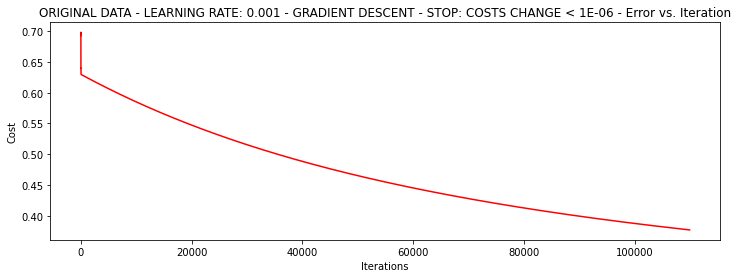

In [21]:
# 根据损失值停止训练，这里设置当损失值小于1e-6时，停止训练
# 最终损失值为0.38
runExpe(orig_data, theta, n, STOP_COST, thresh=0.000001, alpha=0.001)

#### 根据梯度变化停止

设定阈值为0.05,差不多需要40000次迭代

***Original data - learning rate: 0.001 - Gradient descent - Stop: gradient norm < 0.05
Theta: [[-2.37033409  0.02721692  0.01899456]] - Iter: 40045 - Last cost: 0.49 - Duration: 5.22s


array([[-2.37033409,  0.02721692,  0.01899456]])

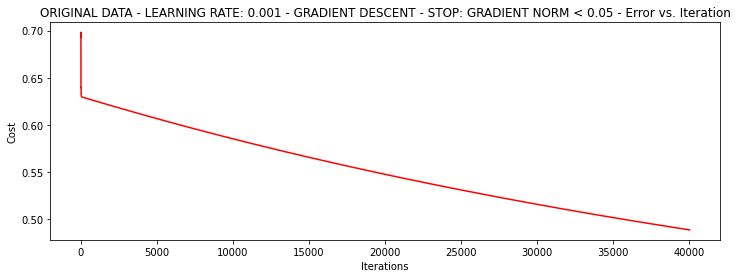

In [22]:
# 根据梯度值的大小停止训练，当梯度值小于0.05时停止训练
# 最终损失为0.49
runExpe(orig_data, theta, n, STOP_GRAD, thresh=0.05, alpha=0.001)

### 对比不同的梯度下降方法

### Stochastic descent(随机梯度下降)

***Original data - learning rate: 0.001 - Stochastic descent - Stop: 5000 iterations
Theta: [[-0.38679642  0.02884255 -0.06573575]] - Iter: 5000 - Last cost: 1.97 - Duration: 0.20s


array([[-0.38679642,  0.02884255, -0.06573575]])

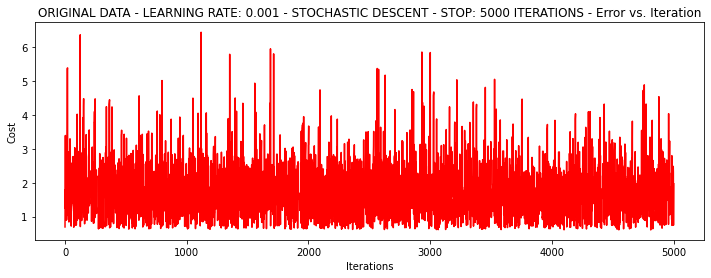

In [23]:
# 上面的所有训练过程都是使用批量梯度下降，即指定batchSize=n
# 下面看看不同的梯度下降策略

# batchSize设置为1，即每次只训练一个样本
# 这里学习率设置得过大，导致结果非常不稳定
runExpe(orig_data, theta, 1, STOP_ITER, thresh=5000, alpha=0.001)

有点爆炸。。。很不稳定,再来试试把学习率调小一些

***Original data - learning rate: 2e-06 - Stochastic descent - Stop: 15000 iterations
Theta: [[-0.00201974  0.01011982  0.00103441]] - Iter: 15000 - Last cost: 0.63 - Duration: 0.58s


array([[-0.00201974,  0.01011982,  0.00103441]])

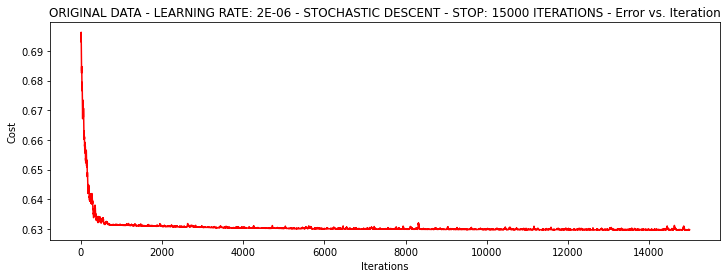

In [24]:
# 将学习率设置得更小，随机梯度下降也能趋向于收敛，但是稳定性较差
runExpe(orig_data, theta, 1, STOP_ITER, thresh=15000, alpha=0.000002)

速度快，但稳定性差，需要很小的学习率

### Mini-batch descent(小批量梯度下降)

***Original data - learning rate: 0.001 - Mini-batch (16) descent - Stop: 15000 iterations
Theta: [[-1.03429127  0.03084492  0.01897531]] - Iter: 15000 - Last cost: 0.76 - Duration: 0.77s


array([[-1.03429127,  0.03084492,  0.01897531]])

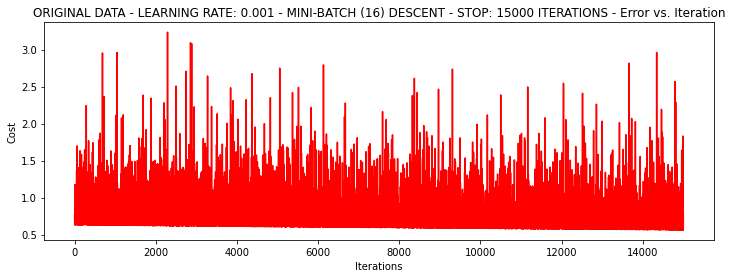

In [25]:
# 每次取16个数据
runExpe(orig_data, theta, 16, STOP_ITER, thresh=15000, alpha=0.001)

浮动仍然比较大，我们来尝试下对数据进行标准化，即把数据按其属性(按列进行)减去其均值，然后除以其方差。
这样最后得到的结果对每个属性/每列来说所有数据都聚集在0附近，方差值为1

***Scaled data - learning rate: 0.001 - Gradient descent - Stop: 5000 iterations
Theta: [[0.3080807  0.86494967 0.77367651]] - Iter: 5000 - Last cost: 0.38 - Duration: 0.65s


array([[0.3080807 , 0.86494967, 0.77367651]])

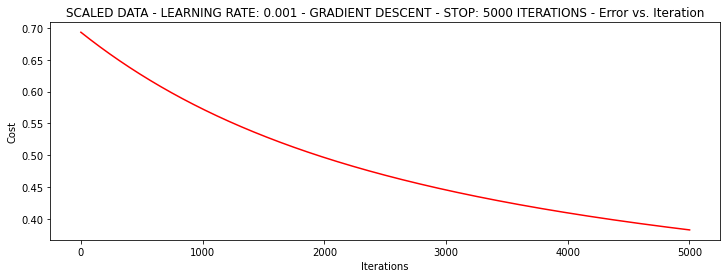

In [26]:
from sklearn import preprocessing

scaled_data = orig_data.copy()

# 这里直接调用sklearn的preprocessing.scale()方法进行数据预处理
# 注意这里只选取1,2两列是因为第0列是之前添加的全1列向量，因此不选第0列
scaled_data[:, 1:3] = preprocessing.scale(orig_data[:, 1:3])

# 数据标准化后，损失值更小，为了对比batchSize先设置为n
runExpe(scaled_data, theta, n, STOP_ITER, thresh=5000, alpha=0.001)

它好多了！原始数据，只能达到达到0.61，而现在我们得到了0.38，所以对数据做预处理是非常重要的

***Scaled data - learning rate: 0.001 - Gradient descent - Stop: gradient norm < 0.02
Theta: [[1.0707921  2.63030842 2.41079787]] - Iter: 59422 - Last cost: 0.22 - Duration: 8.15s


array([[1.0707921 , 2.63030842, 2.41079787]])

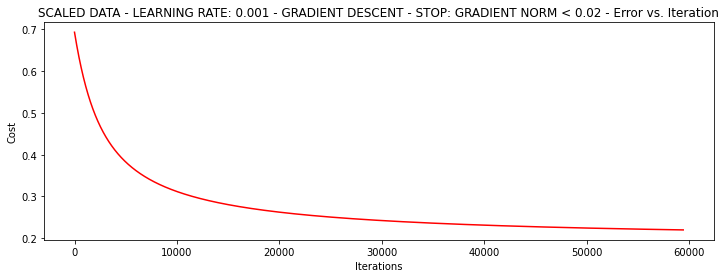

In [27]:
# 使用另一个停止策略，梯度值小于0.02时停止训练
runExpe(scaled_data, theta, n, STOP_GRAD, thresh=0.02, alpha=0.001)

***Scaled data - learning rate: 0.001 - Stochastic descent - Stop: gradient norm < 0.0004
Theta: [[1.1492635  2.79361932 2.56338705]] - Iter: 72560 - Last cost: 0.22 - Duration: 3.53s


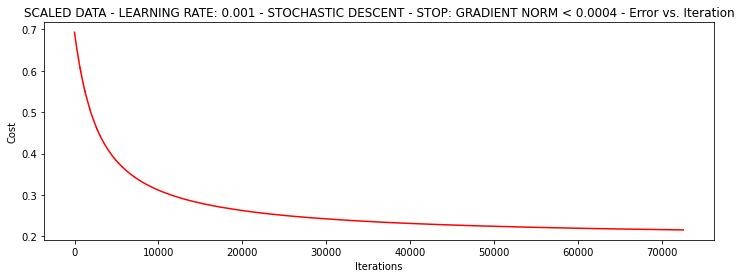

In [28]:
# batchSize=1
theta = runExpe(scaled_data, theta, 1, STOP_GRAD, thresh=0.0004, alpha=0.001)

随机梯度下降更快，但是我们需要迭代的次数也需要更多，所以还是用batch的比较合适！！！

***Scaled data - learning rate: 0.001 - Mini-batch (16) descent - Stop: gradient norm < 0.004
Theta: [[1.16963721 2.83246675 2.6055745 ]] - Iter: 3800 - Last cost: 0.21 - Duration: 0.24s


array([[1.16963721, 2.83246675, 2.6055745 ]])

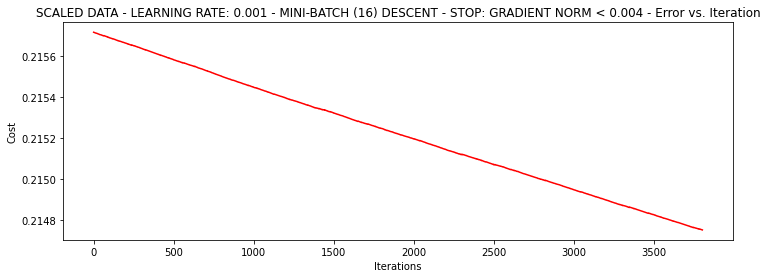

In [29]:
# batchSize=16
runExpe(scaled_data, theta, 16, STOP_GRAD, thresh=0.004, alpha=0.001)

## 模型评估

In [30]:
# 设定阈值，即如果概率值大于0.5设置为正类(录取)，否则为负类(不录取)
def predict(X, theta): return [1 if x >= 0.5 else 0 for x in model(X, theta)]

In [31]:
scaled_X = scaled_data[:, :3]
y = scaled_data[:, 3]

# 使用训练好的theta去预测结果
predictions = predict(scaled_X, theta)

correct = [1 if ((a == 1 and b == 1) or (a == 0 and b == 0)) else 0 for (a, b) in zip(predictions, y)]

# 看看这里的准确率是怎么算的
accuracy = (sum(map(int, correct)) % len(correct))

print ('accuracy = {0}%'.format(accuracy))

accuracy = 89%
